In [1]:
!pip install kaggle

In [2]:
!kaggle competitions download -c titanic

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile

with zipfile.ZipFile('titanic.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.impute import KNNImputer
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix,classification_report, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [94]:
titanic_test = pd.read_csv('test.csv')
titanic_train = pd.read_csv('train.csv')

In [95]:
titanic_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [96]:
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [97]:
titanic_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [98]:
titanic_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [99]:
missing_percentage_test = titanic_test.isnull().mean() * 100
missing_percentage_train = titanic_train.isnull().mean() * 100

In [100]:
print(missing_percentage_train)
print(missing_percentage_test)

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64
PassengerId     0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            20.574163
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.239234
Cabin          78.229665
Embarked        0.000000
dtype: float64


We should get rid of 'Cabin' column in both datasets, as more than 50% of data is unknown. And also we don't need the 'Name' column.

In [101]:
titanic_train.drop(['Cabin', 'Name'], axis = 1, inplace = True)
titanic_test.drop(['Cabin', 'Name'], axis = 1, inplace = True)

Let's check which passengers have 'Embarked' values missed:

In [102]:
missing_embarked = titanic_train[titanic_train['Embarked'].isnull()]
missing_embarked

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,1,female,38.0,0,0,113572,80.0,NaN
829,830,1,1,female,62.0,0,0,113572,80.0,NaN


These passengers have the same ticket number, probably they embarked together in the same port. Let's check, maybe someone else had the same ticket number.

In [103]:
titanic_train[titanic_train['Ticket'] == '113572']

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,1,female,38.0,0,0,113572,80.0,NaN
829,830,1,1,female,62.0,0,0,113572,80.0,NaN


Then let's replace it with the mode:

In [104]:
titanic_train['Embarked'].mode()

0    S
Name: Embarked, dtype: object

In [105]:
titanic_train['Embarked'].fillna('S', inplace = True)

Now let's see how we impute the lacked values for 'Age' column.
I'm planning on using KNN, but we need to decide which values could help us to predict 'Age' values.

Let's use a correlation matrix!

For a correlation matrix we need only numeric columns, so let's make our binary 'Sex' column 'Female' = 1, 'Male' = 0.
And for categorical columns with more than 2 attributes we will use get_dummies:

In [108]:
titanic_train['Sex'] = titanic_train['Sex'].map({'male': 0, 'female': 1}).astype(int)

In [109]:
titanic_train = titanic_train.drop('Ticket', axis = 1)

In [110]:
get_dummies_cols = ['Pclass', 'SibSp', 'Parch', 'Embarked']

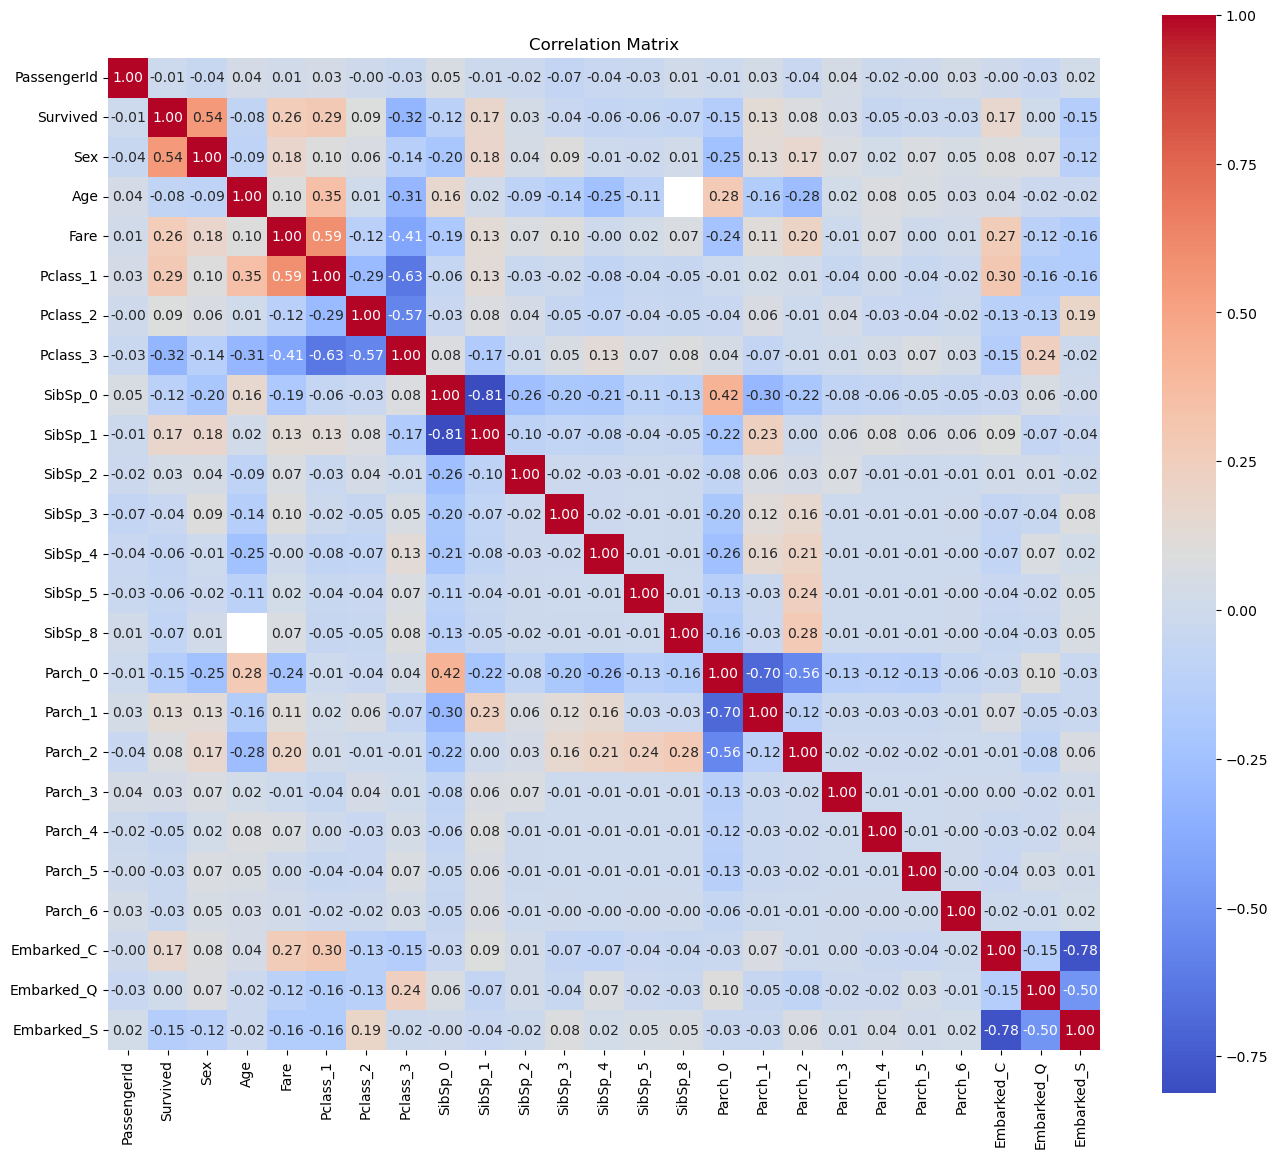

In [111]:
corr_matrix = pd.get_dummies(data = titanic_train, columns = get_dummies_cols).corr()
plt.figure(figsize = (16,14))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

My strongest correlations with 'Age' to predict it with KNN are:
pclass1 = 35%, pclass3 = -31%, parch0 = 28%, parch2 = -28%.

Now let's split our dataset to train and test for a KNN algorithm to impute the 'Age' NaN values:

In [113]:
titanic_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.0,1,0,7.2500,S
1,2,1,1,1,38.0,1,0,71.2833,C
2,3,1,3,1,26.0,0,0,7.9250,S
3,4,1,1,1,35.0,1,0,53.1000,S
4,5,0,3,0,35.0,0,0,8.0500,S


In [114]:
X_train, X_test = train_test_split(
    titanic_train[['Pclass', 'Parch', 'Age']],
    test_size=0.3,
    random_state=0,
)

In [115]:
imputer = KNNImputer(n_neighbors=5,weights="distance").set_output(transform='pandas')

In [116]:
imputer.fit(X_train)

KNNImputer(weights='distance')

In [117]:
X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

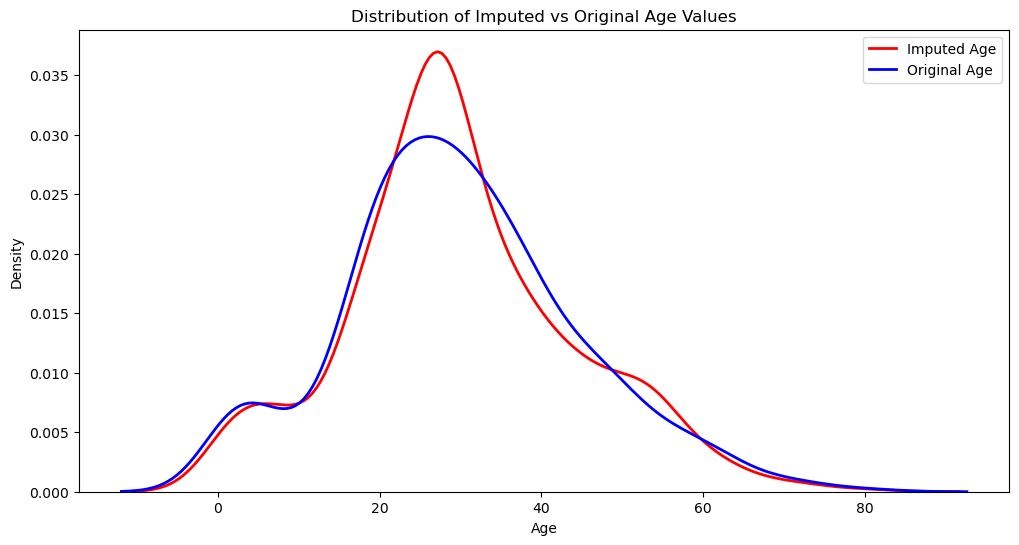

In [118]:
mask_imputed = X_train['Age'].isna()

plt.figure(figsize=(12, 6))
sns.kdeplot(X_train_imputed['Age'], label='Imputed Age', color='red', linewidth=2)
sns.kdeplot(X_train[~mask_imputed]['Age'], label='Original Age', color='blue', linewidth=2)
plt.title('Distribution of Imputed vs Original Age Values')
plt.legend()
plt.show()

In [119]:
imputed_stats = X_train_imputed['Age'].describe()

original_stats = X_train[~mask_imputed]['Age'].describe()

print("Imputed 'Age' stats:\n", imputed_stats)
print("\nOriginal (non-missing) 'Age' stats:\n", original_stats)

Imputed 'Age' stats:
 count    623.000000
mean      29.965490
std       14.099624
min        0.670000
25%       22.000000
50%       27.400000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Original (non-missing) 'Age' stats:
 count    502.000000
mean      29.915339
std       14.506994
min        0.670000
25%       21.000000
50%       29.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64


In [120]:
X_combined_imputed = pd.concat([X_train_imputed, X_test_imputed])

titanic_train.loc[X_combined_imputed.index, 'Age'] = X_combined_imputed['Age']

print(titanic_train['Age'].isnull().sum())

0


In [121]:
titanic_train_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int32  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int32(1), int64(4), object(1)
memory usage: 52.3+ KB


In [122]:
titanic_test[titanic_test['Fare'].isnull()]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
152,1044,3,male,60.5,0,0,3701,NaN,S


In [123]:
titanic_train['Fare'].max()

512.3292

C:\Users\untry\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


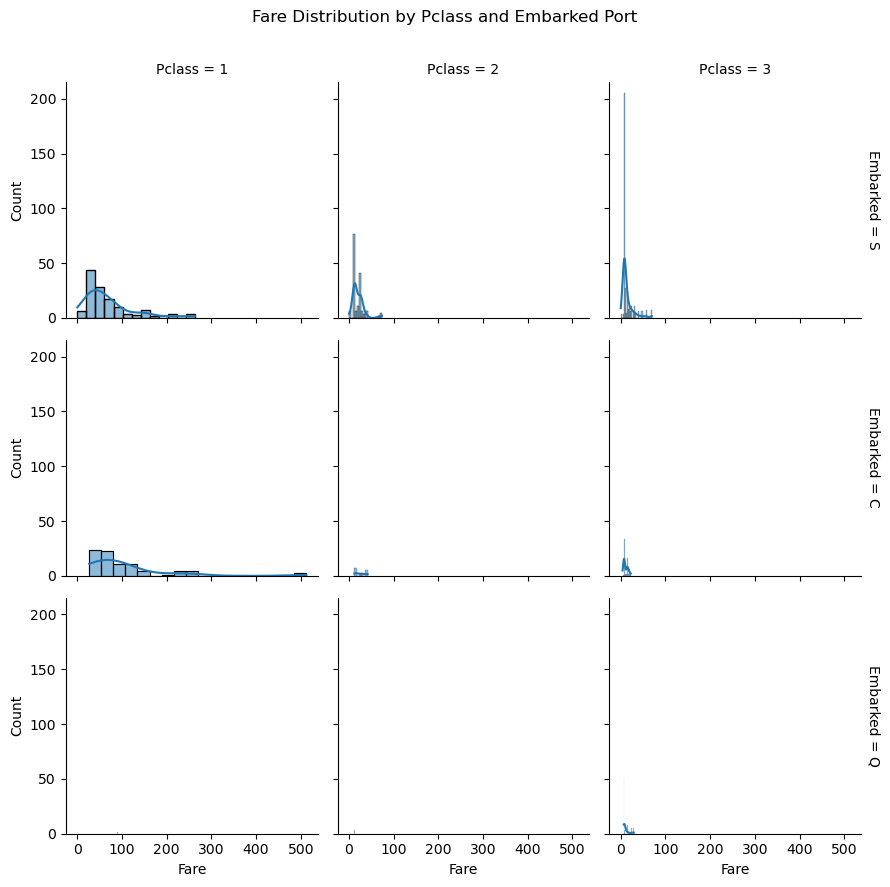

In [124]:
g = sns.FacetGrid(titanic_train_new, col="Pclass", row="Embarked", margin_titles=True)
g.map(sns.histplot, "Fare", kde=True)
g.set_axis_labels("Fare", "Count")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Fare Distribution by Pclass and Embarked Port')
plt.show()

In [125]:
titanic_test[(titanic_test['Pclass'] == 3) & (titanic_test['Embarked'] == 'S')]['Fare'].mean()

13.913029787234043

In [126]:
titanic_test['Fare'].fillna(13.913, inplace = True)

In [127]:
titanic_test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,male,34.5,0,0,330911,7.8292,Q
1,893,3,female,47.0,1,0,363272,7.0000,S
2,894,2,male,62.0,0,0,240276,9.6875,Q
3,895,3,male,27.0,0,0,315154,8.6625,S
4,896,3,female,22.0,1,1,3101298,12.2875,S


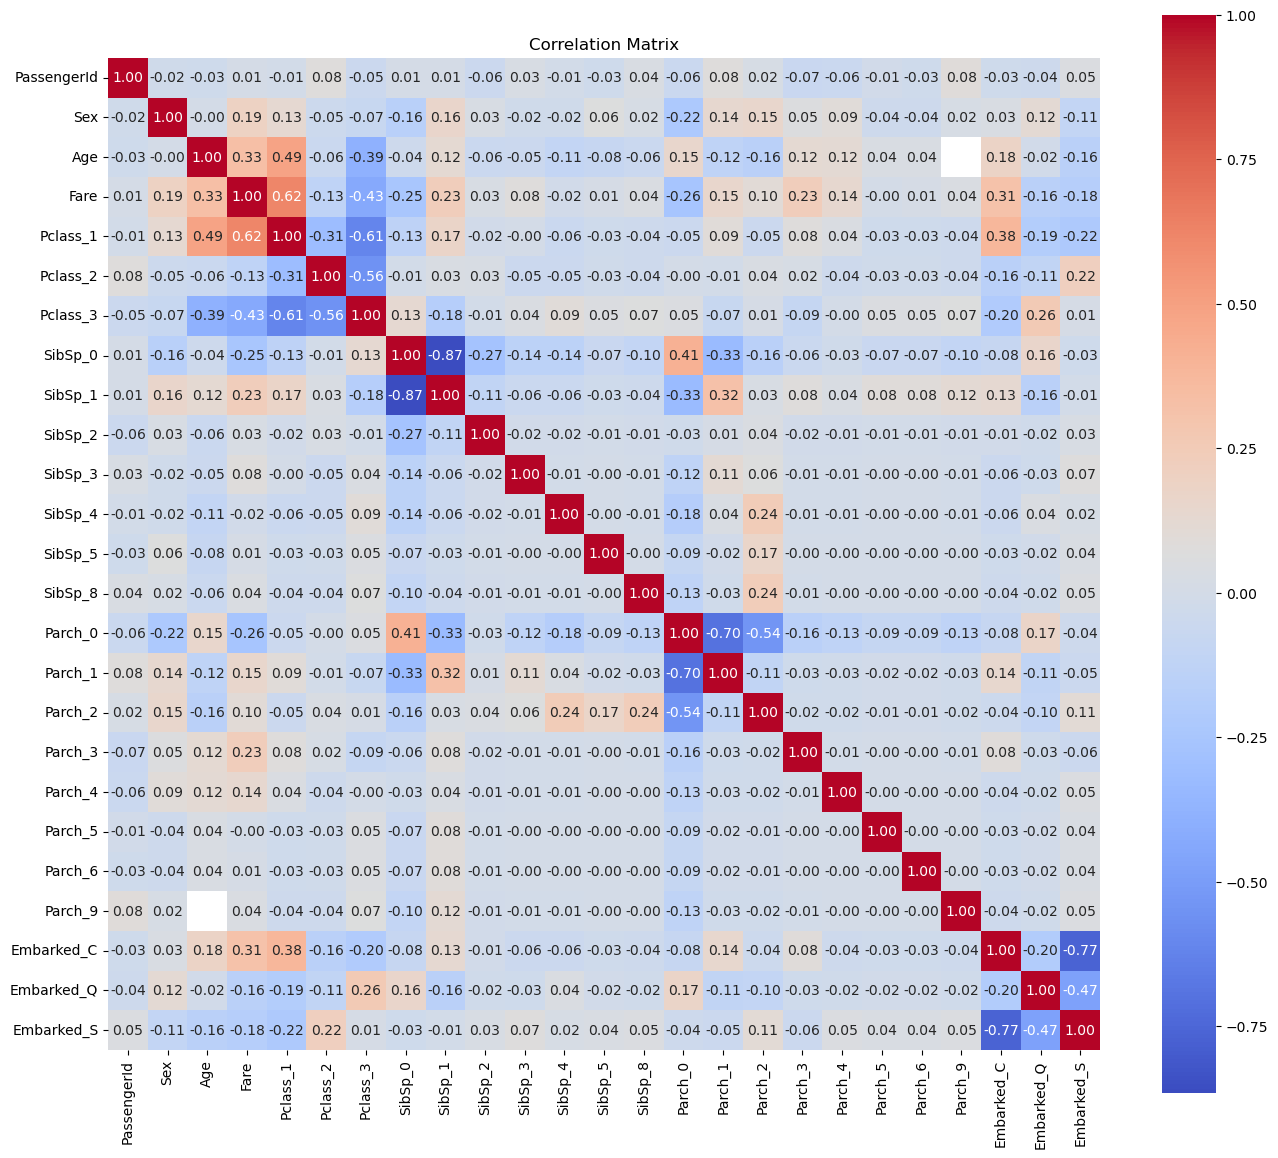

In [128]:
titanic_test['Sex'] = titanic_test['Sex'].map({'male': 0, 'female': 1}).astype(int)
titanic_test = titanic_test.drop('Ticket', axis = 1)
get_dummies_cols = ['Pclass', 'SibSp', 'Parch', 'Embarked']

corr_matrix = pd.get_dummies(data = titanic_test, columns = get_dummies_cols).corr()
plt.figure(figsize = (16,14))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [130]:
X_train1, X_test1 = train_test_split(
    titanic_test[['Pclass', 'Fare', 'Age']],
    test_size=0.3,
    random_state=0,
)

In [131]:
imputer = KNNImputer(n_neighbors=5,weights="distance").set_output(transform='pandas')
imputer.fit(X_train1)

KNNImputer(weights='distance')

In [132]:
X_train_imputed1 = imputer.transform(X_train1)
X_test_imputed1 = imputer.transform(X_test1)

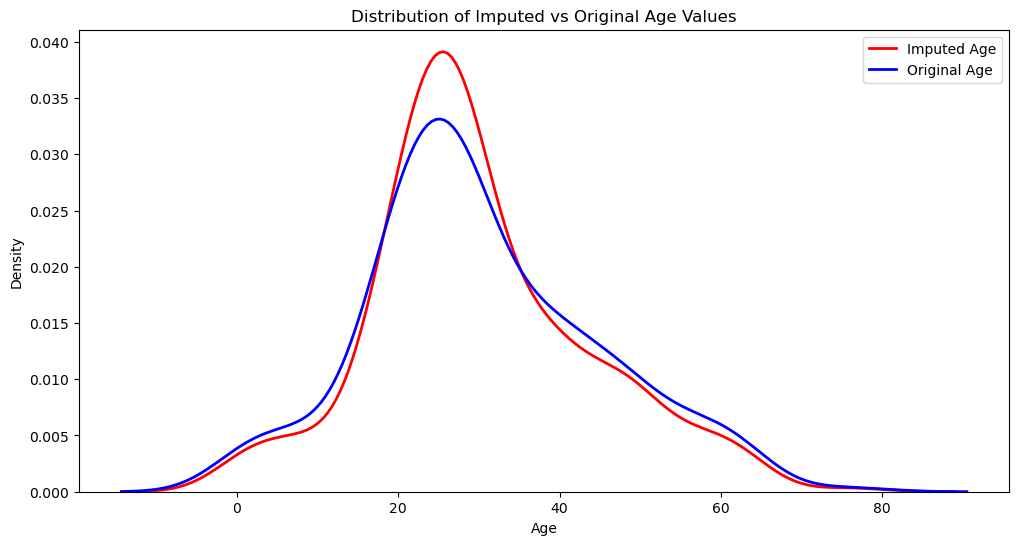

In [133]:
mask_imputed1 = X_train1['Age'].isna()

plt.figure(figsize=(12, 6))
sns.kdeplot(X_train_imputed1['Age'], label='Imputed Age', color='red', linewidth=2)
sns.kdeplot(X_train1[~mask_imputed1]['Age'], label='Original Age', color='blue', linewidth=2)
plt.title('Distribution of Imputed vs Original Age Values')
plt.legend()
plt.show()

In [134]:
imputed_stats1 = X_train_imputed1['Age'].describe()

original_stats1 = X_train1[~mask_imputed1]['Age'].describe()

print("Imputed 'Age' stats:\n", imputed_stats1)
print("\nOriginal (non-missing) 'Age' stats:\n", original_stats1)

Imputed 'Age' stats:
 count    292.000000
mean      30.070610
std       13.414712
min        0.170000
25%       22.000000
50%       27.600000
75%       38.000000
max       76.000000
Name: Age, dtype: float64

Original (non-missing) 'Age' stats:
 count    236.000000
mean      30.489746
std       14.410949
min        0.170000
25%       21.000000
50%       28.000000
75%       39.250000
max       76.000000
Name: Age, dtype: float64


In [135]:
X_combined_imputed1 = pd.concat([X_train_imputed1, X_test_imputed1])

titanic_test.loc[X_combined_imputed1.index, 'Age'] = X_combined_imputed1['Age']

print(titanic_test['Age'].isnull().sum())

0


In [136]:
titanic_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    int32  
 3   Age          418 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Fare         418 non-null    float64
 7   Embarked     418 non-null    object 
dtypes: float64(2), int32(1), int64(4), object(1)
memory usage: 24.6+ KB


In [158]:
train_data = pd.get_dummies(data = titanic_train, columns = get_dummies_cols)

In [170]:
y = train_data['Survived']
X = train_data.drop(['Survived'], axis = 1)

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [172]:
classifiers = {
    'Logistic Regression': LogisticRegression(solver='liblinear',class_weight='balanced'),
    'Linear SVC': SVC(kernel='linear', C = 1, probability=True, random_state=0),
    'KNN classifier': KNeighborsClassifier(n_neighbors = 3),
    'SVC': SVC(C = 1, probability=True, random_state=0),
    'RFST': RandomForestClassifier(n_estimators=100),
    'ADA': AdaBoostClassifier(n_estimators=100)
}

In [173]:
n_classifiers = len(classifiers)

for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X_train, y_train)

    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy (train) for %s: %0.1f%% " % (name, accuracy * 100))
    print(classification_report(y_test,y_pred))

Accuracy (train) for Logistic Regression: 78.0% 
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       157
           1       0.73      0.75      0.74       111

    accuracy                           0.78       268
   macro avg       0.77      0.78      0.77       268
weighted avg       0.78      0.78      0.78       268

Accuracy (train) for Linear SVC: 79.5% 
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       157
           1       0.79      0.69      0.74       111

    accuracy                           0.79       268
   macro avg       0.79      0.78      0.78       268
weighted avg       0.79      0.79      0.79       268

Accuracy (train) for KNN classifier: 62.7% 
              precision    recall  f1-score   support

           0       0.65      0.79      0.71       157
           1       0.57      0.40      0.47       111

    accuracy                           0.63      

In [148]:
test_data = pd.get_dummies(data = titanic_test, columns = get_dummies_cols)

In [168]:
train_data.columns

Index(['PassengerId', 'Survived', 'Sex', 'Age', 'Fare', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4',
       'SibSp_5', 'SibSp_8', 'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3',
       'Parch_4', 'Parch_5', 'Parch_6', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Parch_9'],
      dtype='object')

In [169]:
test_data.columns

Index(['PassengerId', 'Sex', 'Age', 'Fare', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'SibSp_0', 'SibSp_1', 'SibSp_2', 'SibSp_3', 'SibSp_4', 'SibSp_5',
       'SibSp_8', 'Parch_0', 'Parch_1', 'Parch_2', 'Parch_3', 'Parch_4',
       'Parch_5', 'Parch_6', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Parch_9'],
      dtype='object')

In [166]:
if 'Parch_9' not in train_data.columns:
    train_data['Parch_9'] = 0

In [167]:
columns = [col for col in test_data.columns if col != 'Parch_9'] + ['Parch_9']
test_data = test_data[columns]

In [189]:
survival_pred = classifiers['Logistic Regression'].predict(test_data)

In [190]:
survival_pred

array([0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0,

In [191]:
submission = pd.DataFrame({
    'PassengerId': test_data['PassengerId'],  
    'Survived': survival_pred                 
})

In [192]:
submission.to_csv('submission.csv', index=False)